# Anomaly Detection on MNIST
 - https://benjoe.medium.com/
 - https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
 - https://www.kaggle.com/code/ninanovikova/real-fake-face-classification-and-visualization

In [1]:
import random

import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_file = '/content/drive/MyDrive/mnist_train.csv'
test_file = '/content/drive/MyDrive/mnist_test.csv'

In [5]:
df = pd.read_csv(test_file)

In [6]:
anom = df[:1000] #1만개의 mnist_test 데이터셋 중에 1000개에 noise를 첨가해서 일부러 비정상 데이터를 만듦 (이상징후 데이터)
clean = df[1000:]

In [7]:
anom

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
anom.iloc[0]

label    7
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Name: 0, Length: 785, dtype: int64

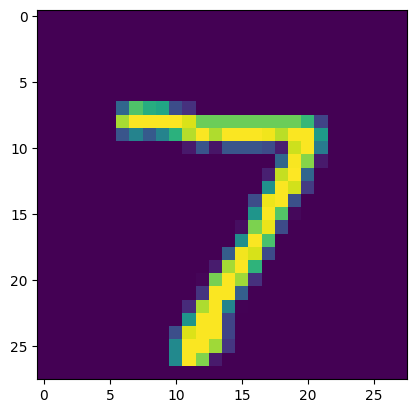

In [9]:
plt.imshow(np.array(anom.iloc[0].tolist()[1:]).reshape((28, 28)))

In [10]:
#noise 추가하는 코드
for i in range(len(anom)):
    # select row from anom (하나의 이미지씩)
    row = anom.iloc[i]
    # iterate through each element in row (한 이미지의 모든 픽셀을 돌아가며 noise 추가)
    for i in range(len(row)-1):
        # add noise to element (각 픽셀에 100~200 사이의 random값 주입하기)
        # => 7 밝은 부분에 + random 더한 부분이랑 검은색 바탕에 +random 더한 부분을 비교해보면 7이라는 숫자를 알아볼 수 있게 유지는 되지만, 픽셀색깔에 변동이 생김.
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [11]:
anom['label'] = 1
clean['label'] = 0

<ipython-input-11-7803411b1b46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anom['label'] = 1
<ipython-input-11-7803411b1b46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['label'] = 0


In [12]:
anom

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,1,197,163,173,179,151,196,113,191,191,...,103,142,158,154,179,195,169,126,167,103
1,1,153,125,155,125,185,165,195,199,149,...,120,153,197,112,122,182,135,166,146,128
2,1,180,156,124,177,155,198,165,132,163,...,121,154,160,193,124,115,175,113,125,173
3,1,105,165,180,163,139,169,160,199,187,...,130,168,171,117,174,139,102,111,125,124
4,1,104,109,161,108,113,177,112,140,120,...,123,163,173,173,159,138,133,115,144,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,195,123,103,123,182,164,146,191,103,...,199,111,132,128,117,120,139,161,182,170
996,1,199,146,101,191,165,136,163,187,180,...,115,153,162,100,139,179,183,150,171,149
997,1,119,160,111,136,100,183,120,158,194,...,160,184,158,174,130,153,129,182,167,165
998,1,112,159,120,171,175,138,109,178,179,...,189,191,117,175,187,124,113,194,155,110


In [13]:
anom.iloc[0].tolist()

[1,
 197,
 163,
 173,
 179,
 151,
 196,
 113,
 191,
 191,
 137,
 181,
 112,
 164,
 138,
 190,
 128,
 198,
 107,
 142,
 177,
 163,
 138,
 184,
 132,
 167,
 120,
 167,
 103,
 144,
 156,
 134,
 128,
 152,
 110,
 190,
 100,
 157,
 161,
 107,
 135,
 194,
 153,
 117,
 191,
 115,
 144,
 101,
 129,
 114,
 173,
 140,
 198,
 110,
 139,
 193,
 125,
 181,
 149,
 180,
 178,
 160,
 116,
 127,
 108,
 162,
 171,
 162,
 185,
 102,
 111,
 145,
 191,
 160,
 194,
 177,
 113,
 111,
 112,
 144,
 116,
 161,
 143,
 127,
 163,
 117,
 122,
 109,
 152,
 186,
 109,
 178,
 135,
 175,
 108,
 187,
 193,
 178,
 175,
 110,
 124,
 170,
 139,
 127,
 168,
 150,
 113,
 160,
 139,
 187,
 176,
 112,
 172,
 131,
 188,
 194,
 164,
 176,
 163,
 143,
 137,
 139,
 193,
 154,
 149,
 117,
 142,
 170,
 197,
 112,
 158,
 186,
 129,
 177,
 114,
 106,
 102,
 130,
 178,
 146,
 175,
 171,
 124,
 130,
 102,
 134,
 180,
 165,
 156,
 179,
 196,
 168,
 118,
 173,
 107,
 134,
 133,
 164,
 169,
 193,
 117,
 174,
 140,
 111,
 101,
 185,
 113,


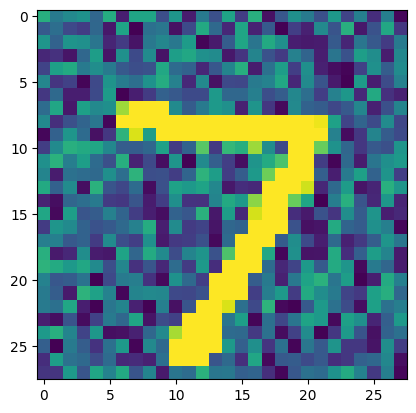

In [14]:
plt.imshow(np.array(anom.iloc[0].tolist()[1:]).reshape((28, 28)))
#변조된 데이터

In [15]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

In [16]:
an_test

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,1,197,163,173,179,151,196,113,191,191,...,103,142,158,154,179,195,169,126,167,103
1,1,153,125,155,125,185,165,195,199,149,...,120,153,197,112,122,182,135,166,146,128
2,1,180,156,124,177,155,198,165,132,163,...,121,154,160,193,124,115,175,113,125,173
3,1,105,165,180,163,139,169,160,199,187,...,130,168,171,117,174,139,102,111,125,124
4,1,104,109,161,108,113,177,112,140,120,...,123,163,173,173,159,138,133,115,144,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Auto Encoder (feed forward network 형태) (여기에 cnn형태를 덧붙일 수도 있음!)
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512), #auto encoder의 특징이 점점 차원을 축소 시켜나가다가(784 -> 512 -> 256...)(self.enc파트), 다시 확장시키는 것(self.dec)
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [18]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9
epochs = 15

In [19]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        #row = row.drop(labels={'label'}, axis=1)
        row = row.drop(labels={'label'}) #label drop
        data = torch.from_numpy(np.array(row)/255).float()
        return data


class Train_Loader(Loader):
    def __init__(self, train_file):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       train_file,
                       index_col=False
                       )

In [20]:
train_set = Train_Loader(train_file)
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE() #Auto Encoder 모델!
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [22]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device)) #mnist_train 데이터셋(이상데이터 없음)을 AE 모델에 적용시킨 것 => 정상 데이터들의 특징을 압축해놓은 것이 담겨있음
        loss = criterion(data.to(device), sample) #loss 계산
        optimizer.zero_grad() #gradient 0으로 초기화
        loss.backward() #오차 역전파 계산
        optimizer.step() #최적화
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0033536008400221664
Epoch Complete in 0:00:51.274252
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.0032527782602856554
Epoch Complete in 0:00:45.525829
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.003149057925119996
Epoch Complete in 0:00:48.832389
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0030374478922535974
Epoch Complete in 0:00:50.913026
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0029183789572368064
Epoch Complete in 0:00:45.468170
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0028072497884432473
Epoch Complete in 0:00:54.470639
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0027248488785078127
Epoch Complete in 0:00:47.576415
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.002678809440881014
Epoch Complete in 0:00:44.791592
------------------

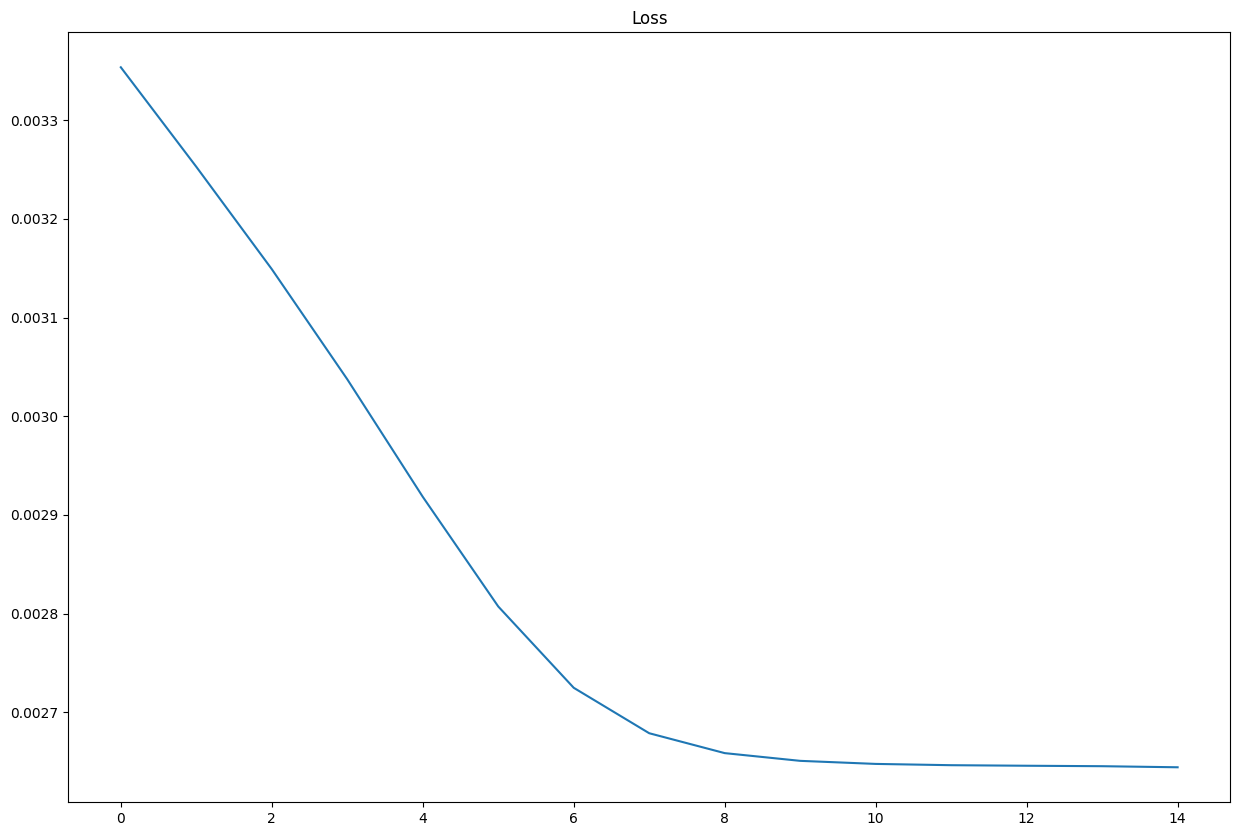

In [23]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [24]:
model.eval()
loss_dist = []
anom = pd.read_csv('./anom.csv', index_col=[0]) #anom.csv에는 이상데이터와 정상데이터가 섞여있음
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device)) #이상데이터를 data로 입력하여, 앞서 train시킨 AE모델에 적용시켰을 때, AE모델이 압축상태로 갖고 있던 정상데이터의 특징과 다른 특징(noise) 때문에, 모델에 적용되어 정상데이터마냥 복원되어 나온 결과가 정상데이터보다는 이상하게 출력될 것
    loss = criterion(data.to(device), sample) # 만약 data가 이상데이터였으면, sample은 noise섞인데이터를 정상데이터마냥 복원시킨 이미지 => loss가 큼
                                              # 근데 data가 정상데이터였으면, sample은 그냥 정상데이터를 잘 복원한 이미지 => loss가 작음
    loss_dist.append(loss.item())

In [25]:
#아마 초반 1000개는 loss값이 0.3이상일 것이고 나머지는 다 loss값이 0.3보다 작을 것
print(loss_dist)

[0.34440988302230835, 0.38717028498649597, 0.32565003633499146, 0.38932564854621887, 0.35283535718917847, 0.32786256074905396, 0.36454421281814575, 0.3558519184589386, 0.38329941034317017, 0.37961527705192566, 0.39188501238822937, 0.3829709589481354, 0.3561447858810425, 0.3849518299102783, 0.33539044857025146, 0.36836007237434387, 0.36190539598464966, 0.36055970191955566, 0.40213486552238464, 0.3436587452888489, 0.3702872395515442, 0.35614287853240967, 0.36227115988731384, 0.3573662042617798, 0.3401736617088318, 0.4375401735305786, 0.3481963872909546, 0.3538341820240021, 0.38863861560821533, 0.32454684376716614, 0.3597153425216675, 0.3190802037715912, 0.36913594603538513, 0.37056776881217957, 0.36336979269981384, 0.38493430614471436, 0.3516736626625061, 0.32544517517089844, 0.3553604185581207, 0.3409298360347748, 0.304513543844223, 0.34364575147628784, 0.36382386088371277, 0.33463171124458313, 0.34210005402565, 0.3519507348537445, 0.3463576138019562, 0.34276825189590454, 0.399678111076

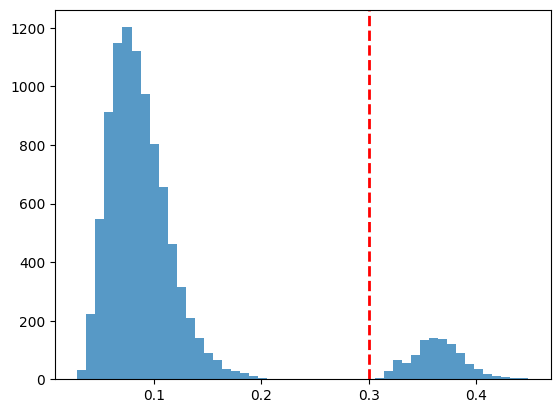

In [26]:
plt.hist(loss_dist, bins=50, alpha=0.75)
plt.axvline(0.3, color='red', linestyle='dashed', linewidth=2)
plt.show()

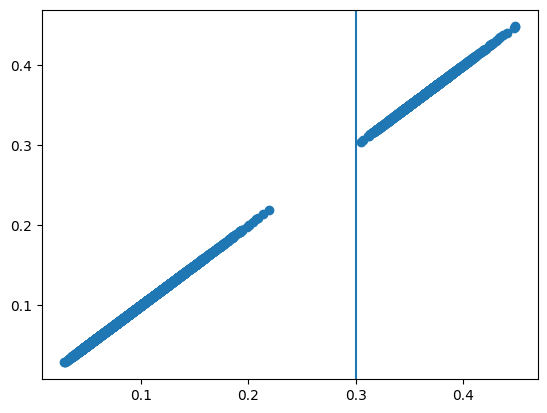

In [27]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

위의 그래프 결과해석 : Loss값이 0.3보다 크면 anomaly data (이상징후)

<ipython-input-28-613975f94484>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loss_dist,bins=100,kde=True, color='blue')


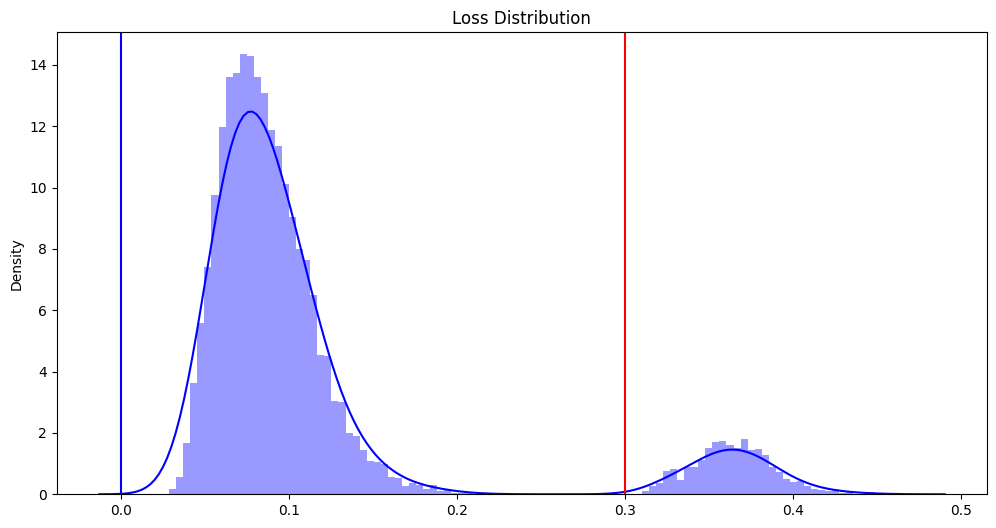

In [28]:
# 분포 시각화
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [29]:
df = pd.read_csv('./anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1 #이상데이터 맞춘 거 (임의로 positive = label이 1(이상데이터)인 거로 정해놓음)
        else:
            fp += 1 #이상데이터인데, 정상데이터로 잘못 예측한 거
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1 #정상데이터인데, 이상데이터로 잘못 예측한 거
        else:
            tn += 1 #정상데이터 맞춘 거 (임의로 negative = label이 0(정상데이터)인 거로 정해놓음)
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


<Axes: >

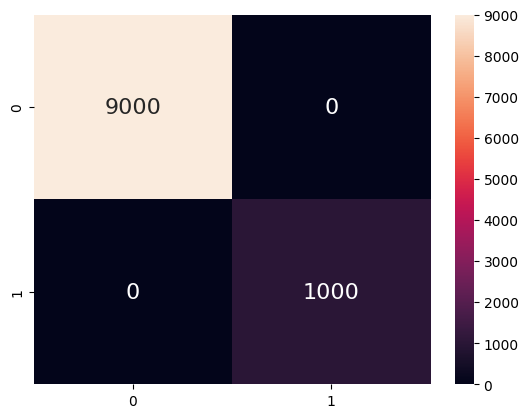

In [30]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')